# Pool 4 TDA

#### Introduction

In addition to running kmapper with the entire LTRM data set, we will also run kmapper with only pool 4 data. This will provide further information about the ecological states of pool 4. When kmapper is applied to the entire data set, we are able to gather information on the global scale. Coloring by field station indicates that the kmapper algorithm is able to group observations by their location without having prior knowlege on this variable. Filtering by pool 4 will provide an opportunity for the algorithm to pick up on aspects missed in the large simplicial complex.

We need to select parameters for running kmapper on pool 4. Recall the heuristics for parameter selection

1. Each cluster has at most 10% of the data
2. The Mapper output represents at least 90% of the data (no more than 10% of the original data, aka 7600 data points, are lost as noise).

#### Outline

This notebook will first make the following alterations to the cleaned and interpolated LTRM data filtered by pool 4:

1. Scale the conintuous variable columns with RobustScaler(). Robust scaler scales the data by subtracting the median and dividing by the IQR for each continuous variable.
2. Adding 5 decade columns with one-hot encoding
3. New coloring columns for each continuous variable with a lower 'ceiling'
4. One-hot encode the stratum


We will then run kmapper with several different combinations of parameter values (epsilon, min samples, cubes, and percent overlap). Recall that we are using PCA 2 as the filter function. We will use the heuristics stated previously to choose a combination of parameters. 

The TDA analysis will include the following steps:

1. Run kmapper on the data set
2. Use the code written by Killan to find the density of each node in a simplicial complex
3. Convert the simplicial complex to a directed graph with arrows pointing to a node with a higher density
4. Local maxium will be defined as sinks of the directed graph
5. States of a local maximum will be made up of the nodes who shorted graph distance to a local maximum is that local maximum
6. Color the simplicial complex by different variables to make inferences about the states in each region of the river
7. Make boxplots of the continuous variables for each state


After this analysis is completed with the entire pool 4 data, we will repeat the process for Lake Pepin observations removed.

# TDA for all of pool 4

## Import libraries

In [1]:
import kmapper as km
from kmapper.plotlyviz import *
import pandas as pd
import numpy as np

import sklearn
#from sklearn import ensemble
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
# from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# scipy for interpolation
# import scipy 
# from scipy.interpolate import *
import hdbscan
import pickle as pk
import json as js
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Plotly and Dash
import plotly.graph_objs as go
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
from ipywidgets import (HBox, VBox)
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")

## Upload data

In [2]:
water20 = pd.read_csv("../../../LTRM data/RF interpolation/water_full.csv")
water20 = water20[["SHEETBAR", "DATE", "LATITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
"TN","TP","TEMP", "DO", "TURB", "VEL", "SS", "WDP", "CHLcal",  "SECCHI", "YEAR", "SEASON"]]

## Scale data with RobustScaler()

In [3]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

ct = ColumnTransformer([('somename', RobustScaler(), continuous_variables)], remainder = 'passthrough')

water_df = ct.fit_transform(water20)

water_df = pd.DataFrame(water_df, columns = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal",
                                             "SHEETBAR", "DATE", "LATTITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
                                             "YEAR", "SEASON"])  

## Make decade columns

In [4]:
eco_time_periods = ['1993-2000', '1898-2004', '2001-2013', '2010-2016', '2014-2020']

for time_period in eco_time_periods:
    begin_year = int(time_period[0:4])
    end_year = int(time_period[5:9])
    
    water_df[time_period] = np.where((water_df['YEAR'] >= begin_year) & (water_df['YEAR'] <= end_year), 1, 0)

## Make dummy columns

In [5]:
to_dummy_vars = ['STRATUM'] #, 'FLDNUM']

for var in to_dummy_vars:
    temp = pd.get_dummies(water_df[var])
    water_df = pd.concat([water_df, temp], axis = 1)

## Filter for Pool 4

In [6]:
pool4 = water_df[water_df['FLDNUM'] == 'Lake City, MN']

In [7]:
pool4['UPPER'] = np.where((pool4['LONGITUDE'] >= -92.33) & (pool4['STRATUM'] != 'Lake Pepin or Swan Lake'), 1, 0)
pool4['LOWER'] = np.where((pool4['LONGITUDE'] <= -92.33) & (pool4['STRATUM'] != 'Lake Pepin or Swan Lake'), 1, 0)
pool4['LAKE_PEPIN'] = np.where(pool4['STRATUM'] == 'Lake Pepin or Swan Lake', 1, 0)

## Kmapper function

The kmapper function will be used only when testing the parameters. After the parameters are chosen, we will use the same code that the function uses, just outside of the function form.

In [8]:
def mapper_pca2_db(df, DBSCAN_EPSILON = 10, DBSCAN_MIN_SAMPLES = 20, N_CUBES = [10,10], PERC_OVERLAP = [.25,.25], 
                    return_with_df = False, print_pca_info = False, make_html = False):
    """
    """
    
    X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]
     
    # for discerning primary variables in PCA 
    continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB","VEL", "TP", "TN", "SS", "CHLcal"]
    
    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    projected_vars = continuous_variables
    projected_var_indices = [var_to_index[var] for var in projected_vars]
    
#     if X.shape[0]<10:
#         #print(X)
#         print("Not enough data in ", title, "_size = ", X.shape[0])
#         return(X.shape[0])
    
    # to match up indices in scomplex with the original dataframe X
    X.reset_index(drop = True, inplace = True) 
    
    # create instance of clustering alg
    cluster_alg = DBSCAN(eps = DBSCAN_EPSILON, min_samples = DBSCAN_MIN_SAMPLES, 
                         metric='euclidean')

    # instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose = 0)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)
    
    if print_pca_info: 
        for j in range(2):
            pc_j = pca.components_[j]
            largest_magnitude = max(abs(pc_j))
            idx_magnitude = np.where(abs(pc_j) == largest_magnitude)[0][0]

            print("*** PCA", j+1, " ***")
            print("Primary variable: ", continuous_variables[idx_magnitude])
            print("Corresponding component: ", pc_j[idx_magnitude])
            print("Explained variance: ", pca.explained_variance_ratio_[j])
    
    summary_variable = mapper.project(np.array(X), projection=projected_var_indices, scaler=None)
    # similar to fit transform
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X, 
                          cover=km.Cover(n_cubes = N_CUBES, perc_overlap = PERC_OVERLAP), 
                          clusterer = cluster_alg)

    summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

    #y = np.array(X['STATE_color'])

    # Make HTML with color values as the continous variables
    color_vals = X['TURB']
    color_names = "turb"
    kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                        color_values = color_vals,
                                                                        color_function_name = color_names)

    if make_html:
        html_output_path = 'epsilon_' + str(DBSCAN_EPSILON) + '_CUBES_' + str(N_CUBES) + '_OVERLAP_' + str(PERC_OVERLAP)+'.html'
        mapper.visualize(scomplex, color_values = color_vals, color_function_name = color_names, 
                         path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables) #, 
                         #custom_tooltips = y, node_color_function = ["mean", "std", "median", "max"])
    
    if return_with_df: 
        return(scomplex, X)

    return(scomplex)

## Parameter selection

### Define the parameters

In [164]:
eps_lst = [1.6]
min_samples_lst = [20]
n_cubes_lst = [[75, 75]]
perc_overlap_lst = [[.5,.5]]

### Make the different simplical complices for different parameter combinations

The following code will print out the parameters used for each simplicial complex, the largest node (the node with the most observations) and the smallest node, and the number of unique samples. The output will be used to select the parameters.

In [165]:
db_params = []
db_scomplex = []

for epsilon in eps_lst: 
    
    for min_samples in min_samples_lst: # min_samples = 10

        for n_cubes in n_cubes_lst: 
            
            for perc in perc_overlap_lst: # perc_overlap = [0.5, 0.5]
        
                db_params.append('epsilon = ' + str(epsilon) + ', min_samples = ' + str(min_samples) + 
                                 ', n_cubes = ' + str(n_cubes) + ", and perc_overlap = " + str(perc))
            
                scomplex, df = mapper_pca2_db(pool4, DBSCAN_EPSILON = epsilon, DBSCAN_MIN_SAMPLES = min_samples,
                                              N_CUBES = n_cubes, PERC_OVERLAP = perc, return_with_df = True)
                
                db_scomplex.append(scomplex)
                
                idx = len(db_params)-1
                
                print("*** ", idx, " ***")
                print(db_params[idx])
    
                all_nodes = db_scomplex[idx].get('nodes')
            
                obsv_per_node = []

                for node in all_nodes:
                    obsv_per_node.append(len(all_nodes.get(node)))
                    
                print("The maximum data points in a node is ", max(obsv_per_node))
                print("The minimum data points in a node is ", min(obsv_per_node))
                print("The number of unique samples is ", get_mapper_graph(db_scomplex[idx])[1]["n_unique"])

***  0  ***
epsilon = 1.6, min_samples = 20, n_cubes = [75, 75], and perc_overlap = [0.5, 0.5]
The maximum data points in a node is  552
The minimum data points in a node is  20
The number of unique samples is  11995


### Selection: We will use epsilon 1.6, min_samples 20, n_cubes [75,75] and perc_overlap [.5, .5]

## Simplicial complex for all of Pool 4

In [28]:
for variable in continuous_variables:
    column_name =  variable + "_color" 

    q25, q75 = np.percentile(pool4[variable], [25, 75])
    iqr = q75 - q25

    ceiling = pool4[variable].quantile(.75) + (3 * iqr)

    pool4[column_name] = np.where(pool4[variable] >= ceiling, ceiling, pool4[variable])

In [29]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
X = pool4#[continuous_variables]

var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
projected_var_indices = [var_to_index[var] for var in continuous_variables]

X.reset_index(drop = True, inplace = True)

cluster_alg = sklearn.cluster.DBSCAN(eps = 1.6, min_samples = 20, metric = 'euclidean')
#cluster_alg = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 10)
pca = PCA(n_components = 2)
lens = pca.fit_transform(X[continuous_variables])

mapper = km.KeplerMapper(verbose = 0)
scomplex = mapper.map(lens, X[continuous_variables], cover = km.Cover(n_cubes = [75, 75], perc_overlap = [.5, .5]), 
                                            clusterer = cluster_alg, remove_duplicate_nodes = True)


## Find states for Pool 4

This code was written by Killian and contains the following steps.

1. Find the density of each node in a simplicial complex
2. Convert the simplicial complex to a directed graph with arrows pointing to a node with a higher density
3. Local maxium will be defined as sinks of the directed graph
4. States of a local maximum will be made up of the nodes who shorted graph distance to a local maximum is that local maximum

In [9]:
# libraries for state functions
from sklearn.neighbors import NearestNeighbors
import queue
import networkx as nx

In [10]:
# functions
def getSubdf(scomplex, shape, df):
    """
    Returns the part of the data frame from the particular shape in the simplicial complex.
    params:
    scomplex: the entire simplicial complex
    shape: the particular shape being inspected (within the simplicial complex)
    df: the entire data frame
    
    Description:
    1. Get all the nodes from the particular simplicial complex. 
    2. Generate the indices we care about from the particular shape. To do this, we read each node and append it's 
    indices to a list. Then, we convert the list to a set and then back to a list to eliminate duplicates.
    3. Return the dataframe with only those indices.
    """
    
    nodes = scomplex.get('nodes')
    indices = []
    npShape = np.array(shape).flatten()
    for node in npShape:
        indices.append(nodes.get(node))
    indices = list(set([item for sublist in indices for item in sublist]))
    subdf = df.loc[indices]
    return subdf

def adjacent(v, scomplex):
    """
    Determines the nodes adjacent to a given vertex
    
    params:
    v: vertex
    scomlex: the entire simplicial complex
    
    Description:
    Determines the nodes that are adjacent to a given vertex.
    """
    
    simplices = scomplex.get('simplices')
    edges = [item for item in simplices if len(item) == 2]
    result = []
    for edge in edges:
        if v in edge:
            for item in edge:
                if item != v:
                    result.append(item)
    return result

def bfs(node, scomplex):
    """
    Conducts a breadth first search to obtain the entire shape from a given node
    params:
    node: the start node
    scomplex: the entire simplicial complex
    
    Description:
    Preforms a breadth first search to obtain the entire shape for a given start node.
    """
    Q = queue.Queue()
    result = []
    result.append(node)
    Q.put(node)
    while not Q.empty():
        v = Q.get()
        adjacentEdges = adjacent(v, scomplex)
        for edge in adjacentEdges:
            if edge not in result:
                result.append(edge)
                Q.put(edge)
    return result

def getShapes(scomplex):
    """
    Gets all of the shapes from a given simplicial complex.
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Obtain all the nodes for the entire complex
    2. For each node, preform a breadth first search to obtain everything in that particular shape. 
    If this entire shape has not already been discovered, add it to the set of results. 
    The result item is a set as the order of the shapes does not matter. The resulting shape is a frozenset
    which means items cannot be added or removed once created, and is needed to allow the set object to have other sets within it.
    3. Convert each shape to a list and the result to a list for easier navigation outside of the function.
    4. Return the result
    
    """
    
    nodes = list(scomplex.get('nodes').keys())
    result = set()
    for node in nodes: # currently does more computations than necessary due to going through every node without considering it is already in a shape
        bfsResult = frozenset(bfs(node, scomplex))
        result.add(bfsResult)
    result = [list(x) for x in result]
    # Sort the list depending on what is decided: nodes or indices. Currently doing it by number of nodes
    result.sort(key = len, reverse = True)
    
    
    
    return result

def condenseShape(shape, scomplex):
    """
    
    params:
    shape: a shape of two nodes. must be 2
    scomplex: the entire simplicial complex
    
    description:
    gets the two nodes a and b
    gets the indices for a and b (what is inside the nodes)
    if a \subseteq b, return b
    elif b \subseteq a, return a 
    else return shape 
    
    """
    nodes = scomplex.get('nodes')
    a = shape[0]
    b = shape[1]
    aIndices = set(nodes.get(a))
    bIndices = set(nodes.get(b))
    
    if aIndices.issubset(bIndices):
        return b
    elif bIndices.issubset(aIndices):
        return a
    else:
        return shape

def clean_getShapes(scomplex):
    """
    Condenses 1-simplices down to 0-simplices when each node 
    is a subset of the other 
    
    params:
    scomplex: the entire simplicial complex
    
    Description:
    1. Get all the shapes from the original getShapes function
    2. For shapes that of length 2, if one is a subset of the other, return the larger of the two
        Otherwise, do nothing
    3. return the clean Shapes list 
    
    """
    shapes = getShapes(scomplex)
    cleanShapes = []
    for shape in shapes:
        if len(shape) == 2:
            shape = condenseShape(shape, scomplex)
            cleanShapes.append([shape])
        else:
            cleanShapes.append(shape)
    return cleanShapes

def k_nearest_neighbors(df, neigh, point, k):
    return neigh.kneighbors([list(df.loc[point])], k)[0].flatten()
    
def calculate_density(scomplex, node, df, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    knn = 0
    n = len(scomplex['nodes'][node])
    for point in scomplex['nodes'][node]:
        distances = k_nearest_neighbors(df, neigh, point, k)
        knn += (sum(distances) / k)
    density = knn / (n*n)
    return (1.0 / density)

def generate_graph(scomplex, shape):
    dg = generate_nodes(scomplex, shape)
    dg = generate_edges(scomplex, shape, dg)
    return dg

def generate_nodes(scomplex, shape):
    dg = nx.DiGraph()
    dg.add_nodes_from(shape)
    return dg

def generate_edges(scomplex, shape, dg):
    for node in shape:
        if node in scomplex['links']:
            for adjacent_node in scomplex['links'][node]:
                if scomplex['density'][node] < scomplex['density'][adjacent_node]:
                    dg.add_edge(node, adjacent_node)
                else:
                    dg.add_edge(adjacent_node, node)
    return dg

def get_local_maxima(dg):
    maxima = []
    for node in list(dg.nodes):
        succ = dict(nx.bfs_successors(dg, source=node))
        if not succ[node]:
            maxima.append(node)
    return maxima

def draw_graph(scomplex, filepath, with_labels = False):
    colors = ['#00A08A', '#e80909', '#F2AD00', '#a6d96a', '#d9ef8b', '#d0e1f0', '#74a7d2',
             '#295981', '#17334a', '#a2a0f7', '#e68a0d', '#a68a52', '#50704a', '#458B74', '#817f85']
    colors_dict = {scomplex['maxima'][i] : colors[i] for i in range(len(scomplex['maxima']))}
    transition_color = '#ffffbf'
    color_map = []
    scomplex['states'] = {scomplex['maxima'][i] : [] for i in range(len(scomplex['maxima']))}
    
    fig = plt.figure(figsize = (12,12))
    ax = plt.subplot(111)

    title = filepath[:-4]
    ax.set_title(title, fontsize = 60)
    
    for node in scomplex['graph']:
        distDict = {scomplex['maxima'][i] : graph_distance(scomplex['graph'], node, scomplex['maxima'][i])
                    for i in range(len(scomplex['maxima']))}
        minDist = min(distDict.values())
        states = [maxima if distDict[maxima] == minDist else None for maxima in scomplex['maxima']]
        states = list(filter(None, states))
        
        for state in states:
            scomplex['states'][state].append(node)
        
        if len(states) > 1:
            color_map.append(transition_color)
        else:
            color_map.append(colors_dict[states[0]])

    
    nx.draw_kamada_kawai(scomplex['graph'], with_labels = with_labels, node_color = color_map)
    plt.tight_layout()
    plt.savefig(filepath, format = "PNG")
    plt.show()

def graph_distance(dg, source, target):
    if nx.has_path(dg, source, target):
        return len(nx.shortest_path(dg, source, target))
    return float('inf')

def append_states(scomplex, shape, df):
    for maximum in scomplex['maxima']:
        entries = [0 for x in range(df.shape[0])]
        for node in scomplex['states'][maximum]:
            for entry in scomplex['nodes'][node]:
                entries[entry] = 1
        df[maximum] = entries
        #water_df = pd.concat([water_df, temp], axis = 1)

In [30]:
# Get the densitites for the simplicial complex
scomplex['density'] = {}
largestShape = clean_getShapes(scomplex)[0]
#print("Largest shape is: ", largestShape, "\n")
largestShape_df = getSubdf(scomplex, largestShape, X[continuous_variables])
k = int((X.shape[0] / 10) + 1)
for node_name in largestShape:
    #scomplex['density'][node_name] = calculate_density(scomplex, node_name, largestShape_df, k)
    scomplex['density'][node_name] = calculate_density(scomplex, node_name, X[continuous_variables], k)

In [31]:
# Make the digraph for the simplicail complex and get the graph maxima
largestShape = clean_getShapes(scomplex)[0]
scomplex['graph'] = {}
scomplex['graph'] = generate_graph(scomplex, largestShape)
scomplex['maxima'] = get_local_maxima(scomplex['graph'])

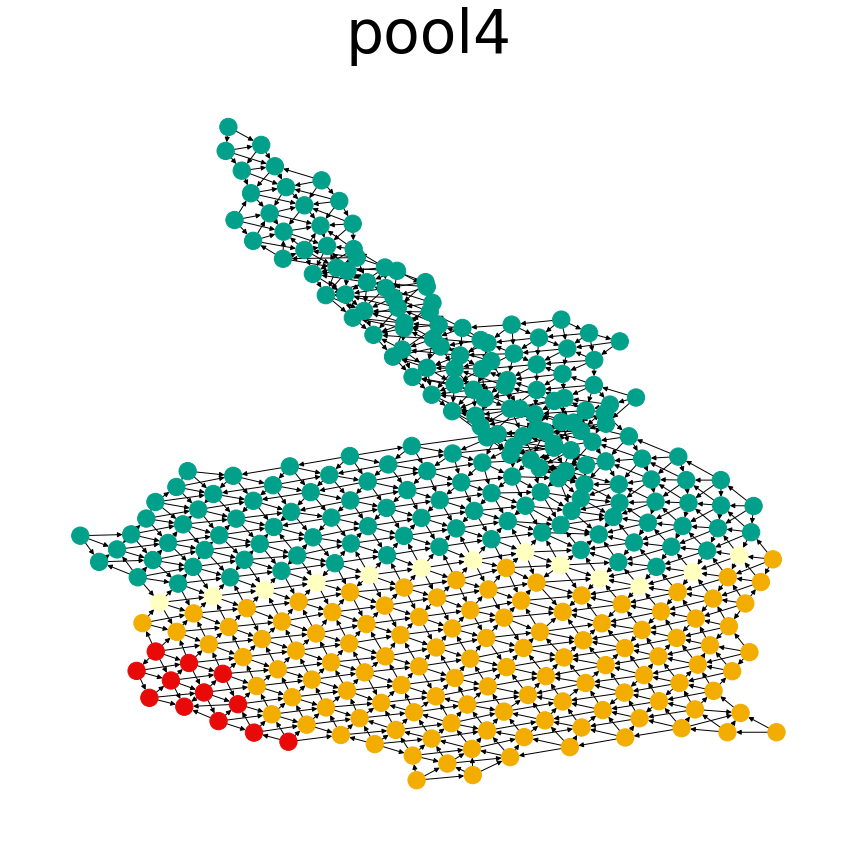

In [40]:
filepath = "pool4.png"
draw_graph(scomplex, filepath, with_labels = False)

In [33]:
append_states(scomplex, largestShape, X)

### Rename maxima columns

In [34]:
X.columns

Index(['WDP', 'SECCHI', 'TEMP', 'DO', 'TURB', 'VEL', 'TP', 'TN', 'SS',
       'CHLcal', 'SHEETBAR', 'DATE', 'LATTITUDE', 'LONGITUDE', 'FLDNUM',
       'STRATUM', 'LOCATCD', 'YEAR', 'SEASON', '1993-2000', '1898-2004',
       '2001-2013', '2010-2016', '2014-2020',
       'Backwater area contiguous to the main channel', 'Impounded',
       'Isolated', 'Lake Pepin or Swan Lake', 'Main channel', 'Side channel',
       'Unexploded Ordinance Area - Pool 13', 'UPPER', 'LOWER', 'LAKE_PEPIN',
       'WDP_color', 'SECCHI_color', 'TEMP_color', 'DO_color', 'TURB_color',
       'VEL_color', 'TP_color', 'TN_color', 'SS_color', 'CHLcal_color',
       'cube307_cluster0', 'cube699_cluster0', 'cube403_cluster0'],
      dtype='object')

In [35]:
X = X.rename(columns = {"cube403_cluster0": "State 1", 
                        "cube307_cluster0": "State 2", 
                        "cube699_cluster0": "State 3"})

In [36]:
X["STATE"] = 0
X["STATE"] = np.where(X['State 1'] == 1, 1/3, X["STATE"])
X["STATE"] = np.where(X['State 2'] == 1, 2/3, X["STATE"])
X["STATE"] = np.where(X['State 3'] == 1, 1, X["STATE"])
X["STATE"] = np.where((X['State 1'] == 1) & (X['State 2'] == 1), 0, X["STATE"])
X["STATE"] = np.where((X['State 1'] == 1) & (X['State 3'] == 1), .33, X["STATE"])
X["STATE"] = np.where((X['State 3'] == 1) & (X['State 2'] == 1), 5/6, X["STATE"])
X["STATE"] = np.where((X['State 3'] == 1) & (X['State 2'] == 1) & (X['State 3'] == 1), 0, X["STATE"])

In [37]:
# Use max for coloring by state
X["STATE_COLOR"] = X["STATE"]
X["STATE_COLOR"][[1158, 8329, 1676, 1165, 2245, 529, 4754, 2452, 4633, 4249, 7048, 3849]] = 1/3

## Scomplex coloring

In [42]:
# Define the list of variable names to color by 
# These will be used when specifying the color function and color names.

continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

continuous_variable_colors =  ["WDP_color", "SECCHI_color", "TEMP_color", "DO_color", 
                                "TURB_color", "VEL_color", "TP_color", "TN_color", 
                                "SS_color", "CHLcal_color"]

pool_names = ['UPPER', 'LOWER', 'LAKE_PEPIN']

decade_names = ['1993-2000', '1898-2004', '2001-2013', '2010-2016', '2014-2020']

stratum_names = ['Backwater area contiguous to the main channel',
                                           'Impounded',
                                            'Isolated',
                             'Lake Pepin or Swan Lake',
                                        'Main channel',
                                        'Side channel']

state_names = ['State 1', 'State 2', 'State 3']

In [ ]:
summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

#y = np.array(X[pool_names])

color_vals = X["pool_names"]
color_names = pool_names
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                    color_values = color_vals,
                                                                    color_function_name = color_names)

html_output_path = 'pool_color_adjusted.html'
    
mapper.visualize(scomplex, color_values = color_vals, color_function_name = color_names, 
                path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables, 
                #custom_tooltips = y, 
                node_color_function = ["mean", "std", "median", "max"])


### Boxplots for each section of Pool 4 (Upper, Lower, Pepin)

In [180]:
pepin = pool4[pool4['STRATUM'] == 'Lake Pepin or Swan Lake']

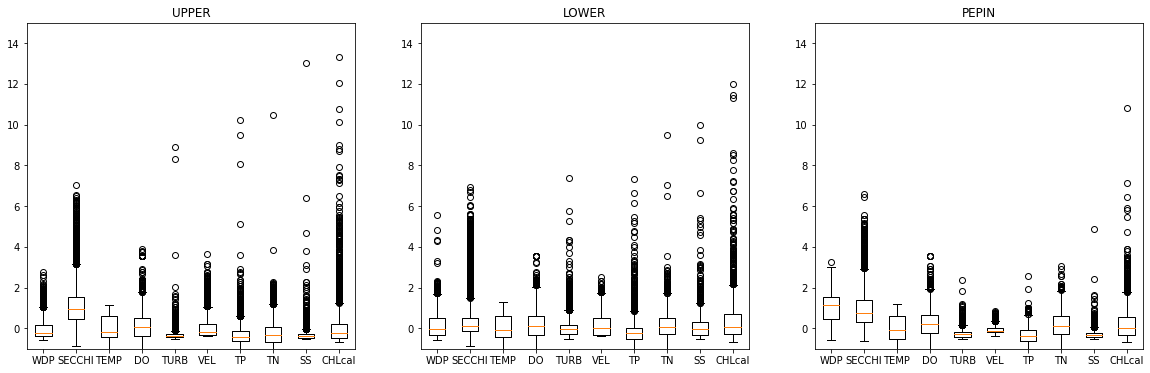

In [183]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor']= 'white'
 
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 6))

bp1 = ax1.boxplot(upper4[continuous_variables],
          vert = True,
          labels = continuous_variables)
ax1.set_title('UPPER')   
ax1.set_ylim(-1, 15)

bp2 = ax2.boxplot(lower4[continuous_variables],
          vert = True,
          labels = continuous_variables)
ax2.set_title('LOWER') 
ax2.set_ylim(-1, 15)

bp3 = ax3.boxplot(pepin[continuous_variables],
          vert = True,
          labels = continuous_variables)
ax3.set_title('PEPIN') 
ax3.set_ylim(-1, 15)

plt.savefig('pool_boxplots.png')

## Boxplots for each state

In [44]:
# Make data subset for each state
state1 = X[X['State 1'] == 1]
state2 = X[X['State 2'] == 1]
state3 = X[X['State 3'] == 1]

poster_vars = continuous_variables

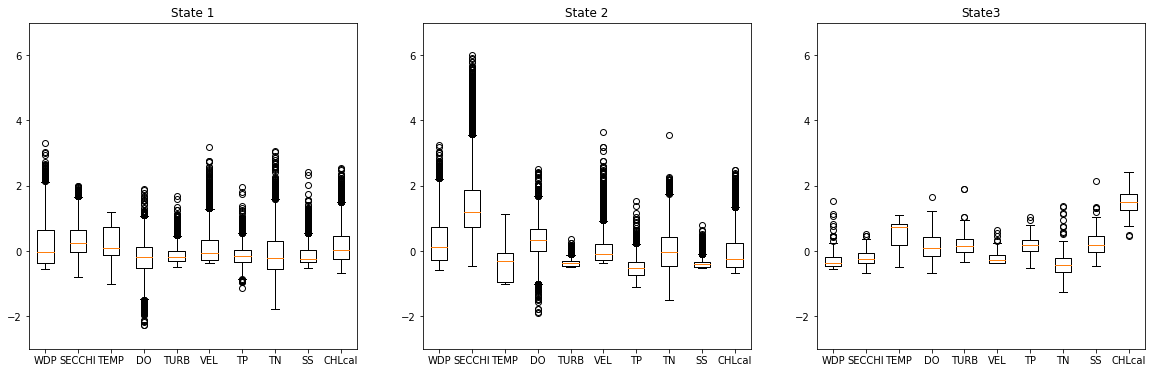

In [45]:
#Make the box plot figure
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor']= 'white'
 
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 6))

bp1 = ax1.boxplot(state1[continuous_variables],
          vert = True,
          labels = continuous_variables)
ax1.set_title('State 1')   
ax1.set_ylim(-3, 7)

bp2 = ax2.boxplot(state2[continuous_variables],
          vert = True,
          labels = continuous_variables)
ax2.set_title('State 2') 
ax2.set_ylim(-3, 7)

bp3 = ax3.boxplot(state3[continuous_variables],
          vert = True,
          labels = continuous_variables)
ax3.set_title('State3') 
ax3.set_ylim(-3, 7)

plt.savefig('state_boxplots.png')

# Use only upper and lower pool 4 - omit lake pepin

In [11]:
pool4_splt = water_df[(water_df['FLDNUM'] == 'Lake City, MN') & (water_df['STRATUM'] != 'Lake Pepin or Swan Lake')]
pool4_splt['UPPER'] = np.where(pool4_splt['LATITUDE'] >= -92.33, 1, 0)
pool4_splt['LOWER'] = np.where(pool4_splt['LATITUDE'] <= -92.33, 1, 0)


### Parameter selection

In [208]:
eps_lst = [1.6]
min_samples_lst = [20]
n_cubes_lst = [[60,60]]
perc_overlap_lst = [[.5,.5]]

In [ ]:
db_params = []
db_scomplex = []

for epsilon in eps_lst: 
    
    for min_samples in min_samples_lst: # min_samples = 10

        for n_cubes in n_cubes_lst: 
            
            for perc in perc_overlap_lst: # perc_overlap = [0.5, 0.5]
        
                db_params.append('epsilon = ' + str(epsilon) + ', min_samples = ' + str(min_samples) + 
                                 ', n_cubes = ' + str(n_cubes) + ", and perc_overlap = " + str(perc))
            
                scomplex, df = mapper_pca2_db(pool4_UL, DBSCAN_EPSILON = epsilon, DBSCAN_MIN_SAMPLES = min_samples,
                                              N_CUBES = n_cubes, PERC_OVERLAP = perc, return_with_df = True)
                
                db_scomplex.append(scomplex)
                
                idx = len(db_params)-1
                
                print("*** ", idx, " ***")
                print(db_params[idx])
    
                all_nodes = db_scomplex[idx].get('nodes')
            
                obsv_per_node = []

                for node in all_nodes:
                    obsv_per_node.append(len(all_nodes.get(node)))
                    
                print("The maximum data points in a node is ", max(obsv_per_node))
                print("The minimum data points in a node is ", min(obsv_per_node))
                print("The number of unique samples is ", get_mapper_graph(db_scomplex[idx])[1]["n_unique"])

#### Parameter Selection: epsilon 1.5, cubes 60, percent overlap 50

## Simplicial complex for Pool 4 without Lake Pepin

In [12]:
# Make a scaled coloring column
for variable in continuous_variables:
    column_name =  variable + "_color" 

    q25, q75 = np.percentile(pool4_splt[variable], [25, 75])
    iqr = q75 - q25

    ceiling = pool4_splt[variable].quantile(.75) + (3 * iqr)

    pool4_splt[column_name] = np.where(pool4_splt[variable] >= ceiling, ceiling, pool4_splt[variable])

In [13]:
continuous_variables = ["WDP","SECCHI","TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
X2 = pool4_splt#[continuous_variables]

var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
projected_var_indices = [var_to_index[var] for var in continuous_variables]

X2.reset_index(drop = True, inplace = True)

cluster_alg = sklearn.cluster.DBSCAN(eps = 1.6, min_samples = 20, metric = 'euclidean')
#cluster_alg = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 10)
pca = PCA(n_components = 2)
lens = pca.fit_transform(X2[continuous_variables])

mapper = km.KeplerMapper(verbose = 0)
scomplex2 = mapper.map(lens, X2[continuous_variables], cover = km.Cover(n_cubes = [60, 60], perc_overlap = [.5, .5]), 
                                            clusterer = cluster_alg, remove_duplicate_nodes = True)


## Determine states for Pool 4 without Lake Pepin

In [14]:
# Get the density for each node in pool4_UL
scomplex2['density'] = {}
largestShape = clean_getShapes(scomplex2)[0]
#print("Largest shape is: ", largestShape, "\n")
largestShape_df = getSubdf(scomplex2, largestShape, X2[continuous_variables])
k = int((X2.shape[0] / 10) + 1)
for node_name in largestShape:
    #scomplex['density'][node_name] = calculate_density(scomplex, node_name, largestShape_df, k)
    scomplex2['density'][node_name] = calculate_density(scomplex2, node_name, X2[continuous_variables], k)

In [15]:
# Fin dthe maxima 
largestShape = clean_getShapes(scomplex2)[0]
scomplex2['graph'] = {}
scomplex2['graph'] = generate_graph(scomplex2, largestShape)
scomplex2['maxima'] = get_local_maxima(scomplex2['graph'])

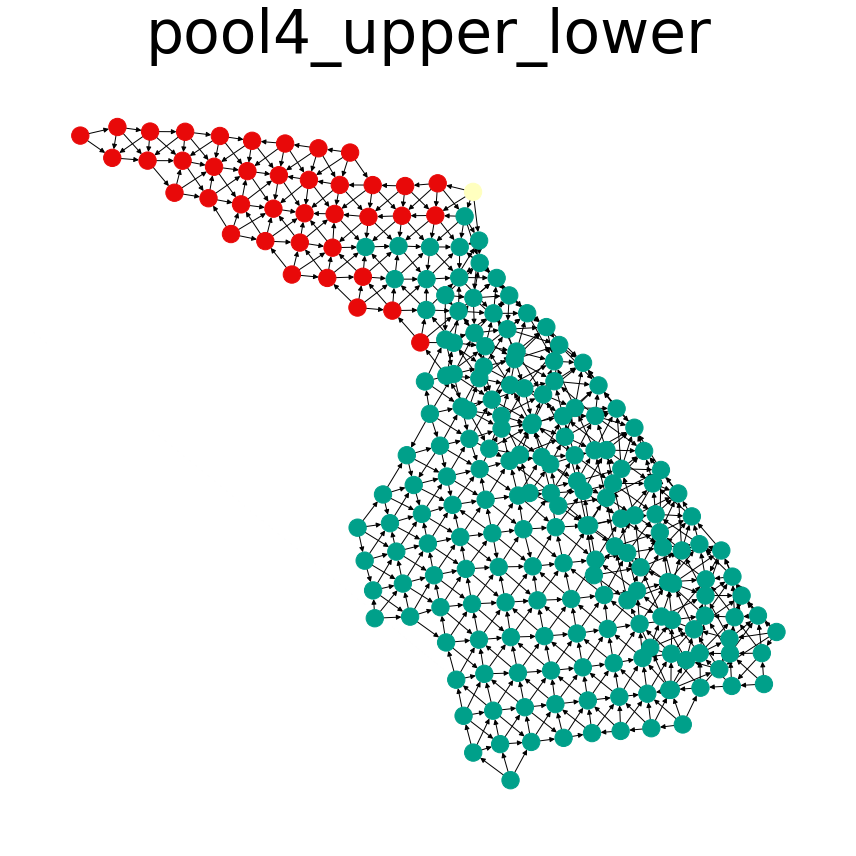

In [16]:
filepath = "pool4_upper_lower.png"
draw_graph(scomplex2, filepath, with_labels = False)

In [17]:
append_states(scomplex2, largestShape, X2)

In [19]:
X2.columns

Index(['WDP', 'SECCHI', 'TEMP', 'DO', 'TURB', 'VEL', 'TP', 'TN', 'SS',
       'CHLcal', 'SHEETBAR', 'DATE', 'LATTITUDE', 'LONGITUDE', 'FLDNUM',
       'STRATUM', 'LOCATCD', 'YEAR', 'SEASON', '1993-2000', '1898-2004',
       '2001-2013', '2010-2016', '2014-2020',
       'Backwater area contiguous to the main channel', 'Impounded',
       'Isolated', 'Lake Pepin or Swan Lake', 'Main channel', 'Side channel',
       'Unexploded Ordinance Area - Pool 13', 'UPPER', 'LOWER', 'WDP_color',
       'SECCHI_color', 'TEMP_color', 'DO_color', 'TURB_color', 'VEL_color',
       'TP_color', 'TN_color', 'SS_color', 'CHLcal_color', 'cube158_cluster0',
       'cube54_cluster0', 'STATE'],
      dtype='object')

In [20]:
X2 = X2.rename(columns = {"cube158_cluster0": "State 1", 
                        "cube54_cluster0": "State 2"})

state_names2 = ['State 1', 'State 2']
pool_names2 = ['UPPER', 'LOWER']

In [21]:
X2["STATE"] = 0
X2["STATE"] = np.where(X2['State 1'] == 1, 1/2, X2["STATE"])
X2["STATE"] = np.where(X2['State 2'] == 1, 1, X2["STATE"])
X2["STATE"] = np.where((X2['State 1'] == 1) & (X2['State 2'] == 1), 0, X2["STATE"])

## Scomplex coloring for pool 4 without Lake Pepin

In [ ]:
summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

y = np.array(X2["STATE"])

# Make HTML with color values as the continous variables
color_vals = X2["STATE"]
color_names = "state"
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex2, 
                                                                    color_values = color_vals,
                                                                    color_function_name = color_names)

html_output_path = 'state2.html'
    
mapper.visualize(scomplex2, color_values = color_vals, color_function_name = color_names, 
                path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables, 
                custom_tooltips = y, node_color_function = ["mean", "std", "median", "max"])

## Boxplots for states in Upper and Lower Pool 4

In [46]:
# Make data subset for each state
state1_splt = X2[X2['State 1'] == 1]
state2_splt = X2[X2['State 2'] == 1]

In [47]:
poster_vars = continuous_variables# ['CHLcal', 'TURB', 'SS', 'SECCHI']

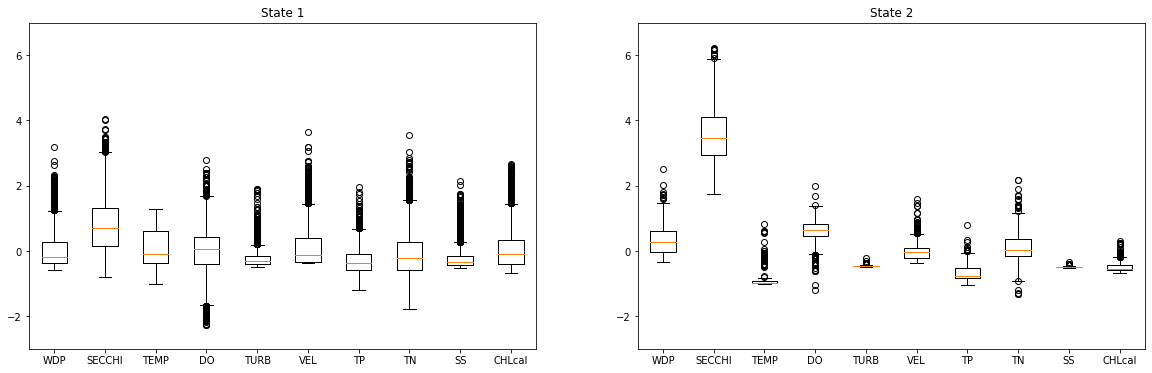

In [48]:
#Make the box plot figure
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor']= 'white'
 
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))

bp1 = ax1.boxplot(state1_splt[poster_vars],
          vert = True,
          labels = poster_vars)
ax1.set_title('State 1')   
ax1.set_ylim(-3, 7)

bp2 = ax2.boxplot(state2_splt[poster_vars],
          vert = True,
          labels = poster_vars)
ax2.set_title('State 2') 
ax2.set_ylim(-3, 7)

plt.savefig('state_boxplots2.png')

### Save dataframes and simplicial complices as pickle files

In [269]:
scomplex_dict = {}
dfs_dict = {}

scomplex_dict2 = {}
dfs_dict2 = {}

scomplex_dict['Pool4_scomplex'] = scomplex
scomplex_dict2['Pool4_splt_scomplex'] = scomplex2
dfs_dict['Pool4_df'] = X
dfs_dict2['Pool4_splt_df'] = X2

In [273]:
pickle = pk.dump(scomplex_dict, open("Pool4_scomplex.p","wb"))
pickle = pk.dump(dfs_dict, open("Pool4_df.p", "wb"))

pickle = pk.dump(scomplex_dict2, open("Pool4_splt_scomplex.p", "wb"))
pickle = pk.dump(dfs_dict2, open("Pool4_splt_df.p", "wb"))